<a href="https://colab.research.google.com/github/326eunjin/ai-team_project/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dropout
from tensorflow.keras.utils import to_categorical,plot_model

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess the data
# Visualize용 y_test 기존 데이터 형태 저장
y_test_origin = y_test

#정규화 및 one-hot encoding
x_train = x_train.astype('float32') / 255.0
y_train = to_categorical(y_train)
x_test = x_test.astype('float32') / 255.0
y_test = to_categorical(y_test)

In [3]:
# Model modeling
model = tf.keras.models.Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3), padding='same'),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Dropout(0.25),
    Conv2D(256, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Dropout(0.25),
    Conv2D(512, 3, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
    Dropout(0.25),
    GlobalAveragePooling2D(),
    Dense(10, activation='softmax')
])

# #original model Test Accuracy:  0.7023000121116638
# model = tf.keras.models.Sequential([
#     Conv2D(32, 3, activation='relu', input_shape=(32, 32, 3), padding='same'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
#     Conv2D(64, 3, activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(10, activation='softmax')
# ])

#layer 0.7267000079154968 0.7376999855041504
# #channel Test Accuracy:  0.7063999772071838
# model = tf.keras.models.Sequential([
#     Conv2D(64, 3, activation='relu', input_shape=(32, 32, 3), padding='same'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
#     Conv2D(256, 3, activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(10, activation='softmax')
# ])

# #dense 늘리기 Test Accuracy:  0.7124000191688538
# model = tf.keras.models.Sequential([
#     Conv2D(64, 3, activation='relu', input_shape=(32, 32, 3), padding='same'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
#     Conv2D(256, 3, activation='relu', padding='same'),
#     MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'),
#     Flatten(),
#     Dense(1024, activation='relu'),
#     Dense(256, activation='relu'),
#     Dense(10, activation='softmax')
# ])

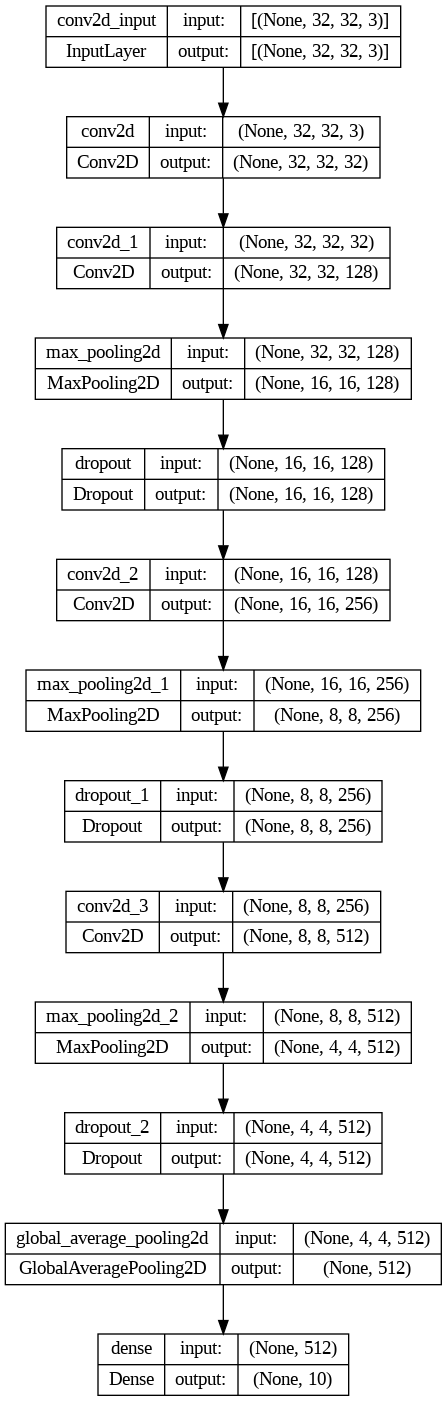

In [4]:
# model 시각화
plot_model(model, show_shapes=True)

In [5]:
# Model Compiling
batch_size=64
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Logging
log_dir = './logs/tensorflow'
tensorboard_cb=keras.callbacks.TensorBoard(log_dir)

In [6]:
# Model Training
epochs = 20
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for _ in range(epochs):
  print(f"epochs {_}:")
  history = model.fit(x_train, y_train, batch_size=batch_size, epochs=1, callbacks=[tensorboard_cb])
  train_loss.append(history.history['loss'][0])
  train_acc.append(history.history['accuracy'][0])
  loss, acc = model.evaluate(x_test, y_test, verbose=0)
  test_loss.append(loss)
  test_acc.append(acc)

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch 1/20
782/782 [==============================] - 29s 26ms/step - loss: 1.5640 - accuracy: 0.4216
Epoch 2/20
782/782 [==============================] - 15s 20ms/step - loss: 1.0837 - accuracy: 0.6138
Epoch 3/20
782/782 [==============================] - 15s 20ms/step - loss: 0.9001 - accuracy: 0.6848
Epoch 4/20
782/782 [==============================] - 16s 20ms/step - loss: 0.7797 - accuracy: 0.7279
Epoch 5/20
782/782 [==============================] - 15s 20ms/step - loss: 0.6906 - accuracy: 0.7610
Epoch 6/20
782/782 [==============================] - 15s 20ms/step - loss: 0.6250 - accuracy: 0.7819
Epoch 7/20
782/782 [==============================] - 17s 22ms/step - loss: 0.5636 - accuracy: 0.8034
Epoch 8/20
782/782 [==============================] - 15s 20ms/step - loss: 0.5155 - accuracy: 0.8232
Epoch 9/20
782/782 [==============================] - 15s 20ms/step - loss: 0.4704 - accuracy: 0.8372
Epoch 10/20
782/782 [==============================] - 15s 20ms/step - loss: 0.430

In [7]:
# Visualize를 위한 차원 축소
pca = PCA(n_components=3)

In [8]:
## Visualization of intermediate model evaluation

# Extract intermediate model
intermediate_model = Sequential(model.layers[:-1])
intermediate_features = intermediate_model.predict(x_test)
reduced_intermediate_features = pca.fit_transform(intermediate_features)

scatter_trace = go.Scatter3d(
    x=reduced_intermediate_features[:, 0],
    y=reduced_intermediate_features[:, 1],
    z=reduced_intermediate_features[:, 2],
    mode='markers',
    marker=dict(
        color=y_test_origin.flatten(),
        colorscale='Viridis',
        size=3,
        opacity=0.8
    )
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')),
    title='Visualization of intermediate model evaluation - categorical crossentropy'
)

fig = go.Figure(data=[scatter_trace], layout=layout)
fig.update_layout(width=800, height=800)
fig.show()


313/313 [==============================] - 1s 2ms/step


In [9]:
## Visualization of model evaluation

test_features = model.predict(x_test)
reduced_test_features = pca.fit_transform(test_features)

scatter_trace = go.Scatter3d(
    x=reduced_test_features[:, 0],
    y=reduced_test_features[:, 1],
    z=reduced_test_features[:, 2],
    mode='markers',
    marker=dict(
        color=y_test_origin.flatten(),
        colorscale='Viridis',
        size=2,
        opacity=0.8
    )
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')),
    title='Visualization of model evaluation'
)

fig = go.Figure(data=[scatter_trace], layout=layout)
fig.update_layout(width=800, height=800)
fig.show()


313/313 [==============================] - 1s 3ms/step


In [10]:
features = model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [11]:
def generate_cam(model, image):
    last_conv_layer = model.get_layer('conv2d_3')

    # 기존 모델에서 마지막 Convolution Layer의 결과값 추출하여 출력
    cam_model = tf.keras.models.Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

    # 이미지 전처리
    img = np.expand_dims(image, axis=0)
    img = img.astype('float32') / 255.0

    features, predictions = cam_model.predict(img)
    label = np.argmax(predictions[0])

    # 각 특징맵에 가중치 행렬곱 연산
    cam = np.dot(features[0], model.get_layer('dense').get_weights()[0][:, label])

    # CAM 이미지와 CIFAR-10 이미지의 크기 매칭 및 정규화
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    # Convert the CAM to a heatmap using a color map
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    # Apply the heatmap to the input image
    cam_image = heatmap * 0.5 + image * 255 * 0.5
    cam_image = np.uint8(cam_image)

    return cam_image


1/1 [==============================] - 0s 173ms/step


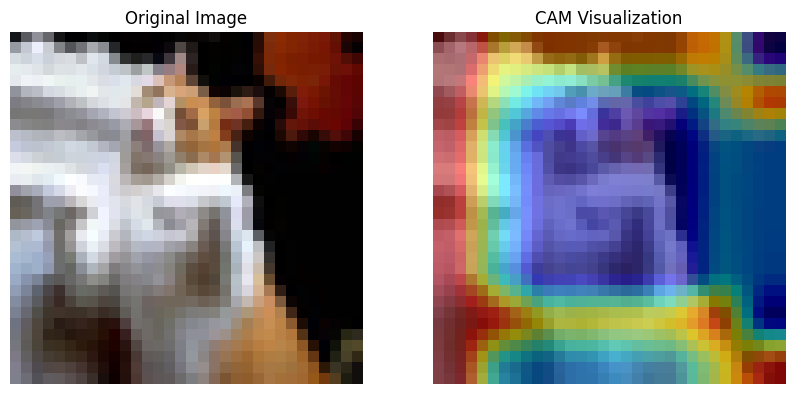

prediction:	horse
answer:		cat
1/1 [==============================] - 0s 89ms/step


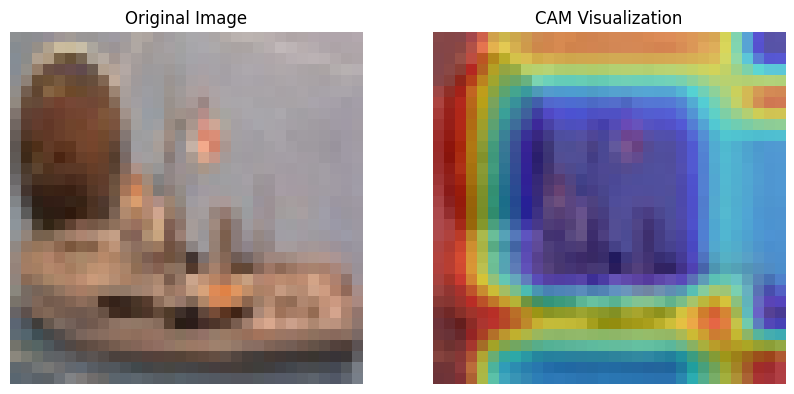

prediction:	ship
answer:		ship
1/1 [==============================] - 0s 88ms/step


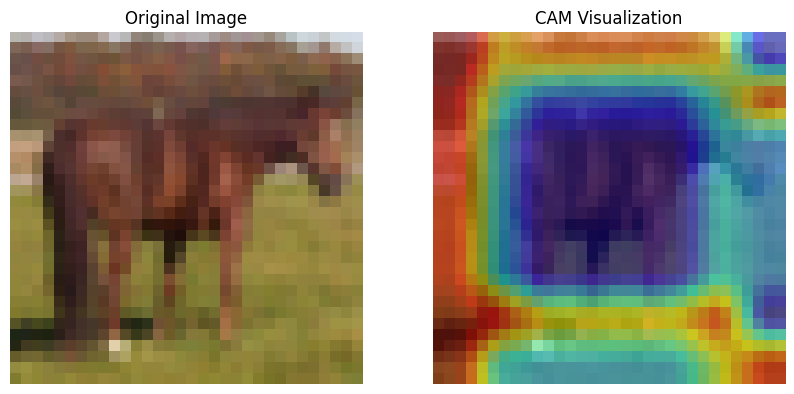

prediction:	horse
answer:		horse


1/1 [==============================] - 0s 83ms/step


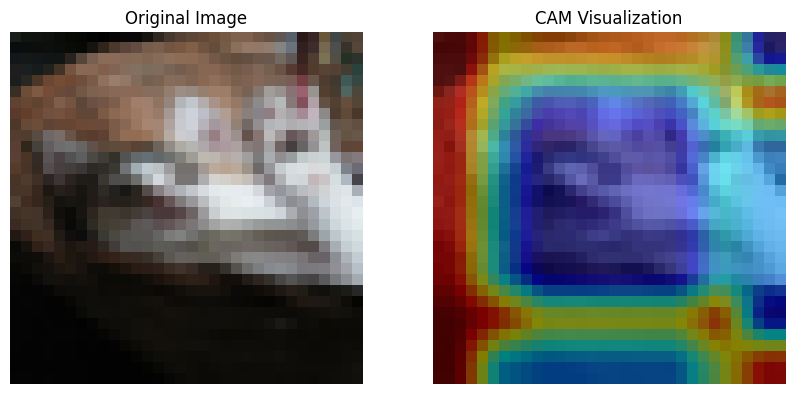

prediction:	cat
answer:		cat
1/1 [==============================] - 0s 88ms/step


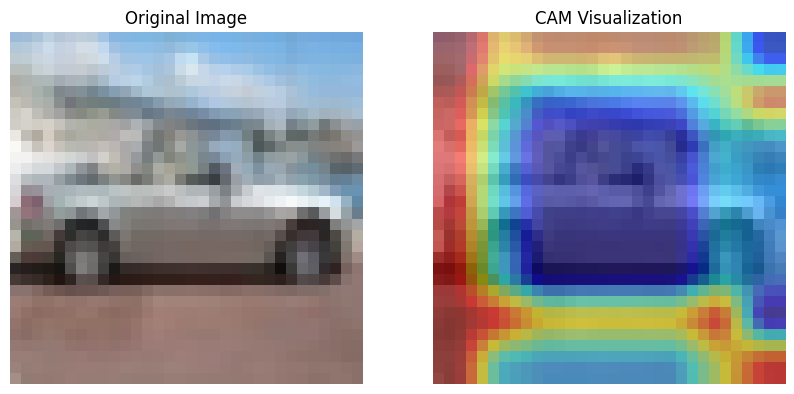

prediction:	automobile
answer:		automobile
1/1 [==============================] - 0s 80ms/step


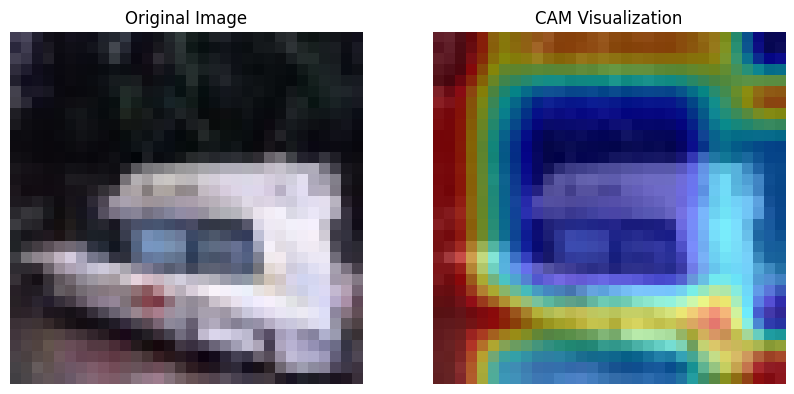

prediction:	automobile
answer:		automobile
1/1 [==============================] - 0s 85ms/step


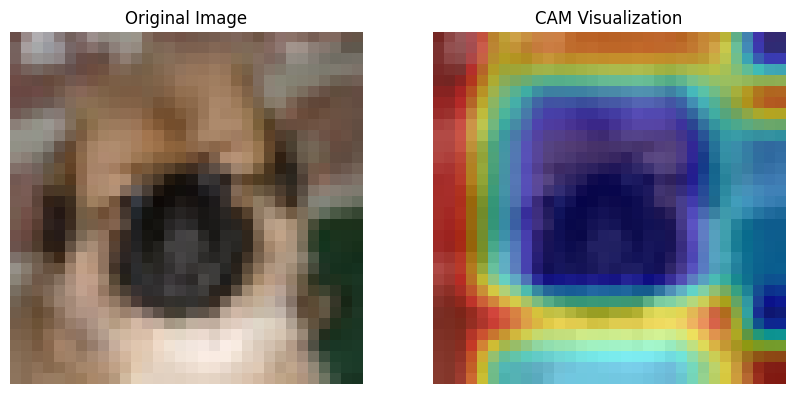

prediction:	dog
answer:		dog
1/1 [==============================] - 0s 85ms/step


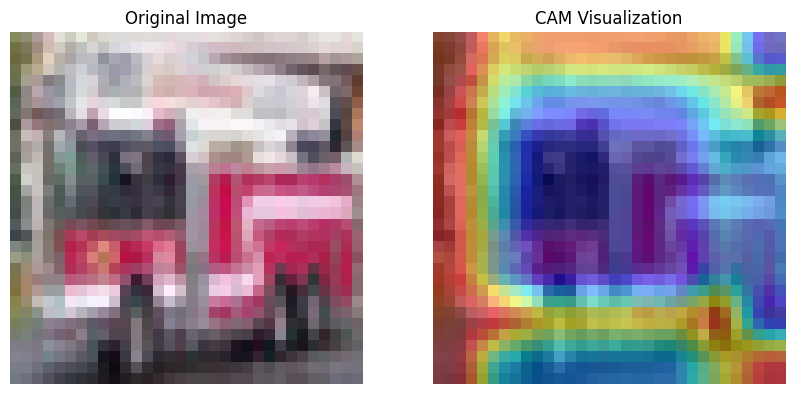

prediction:	truck
answer:		truck
1/1 [==============================] - 0s 80ms/step


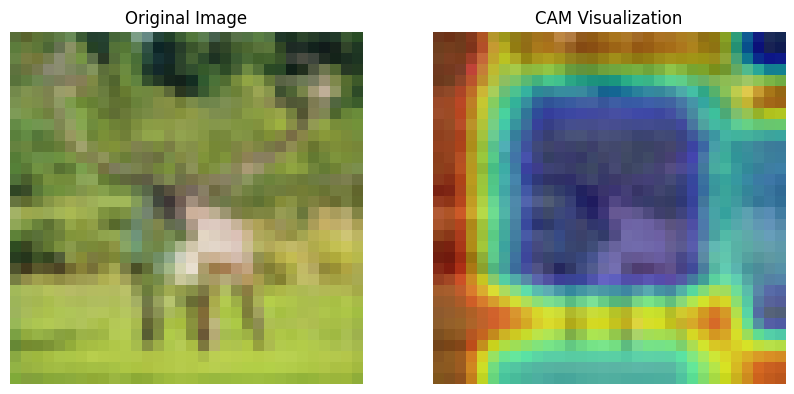

prediction:	deer
answer:		deer
1/1 [==============================] - 0s 78ms/step


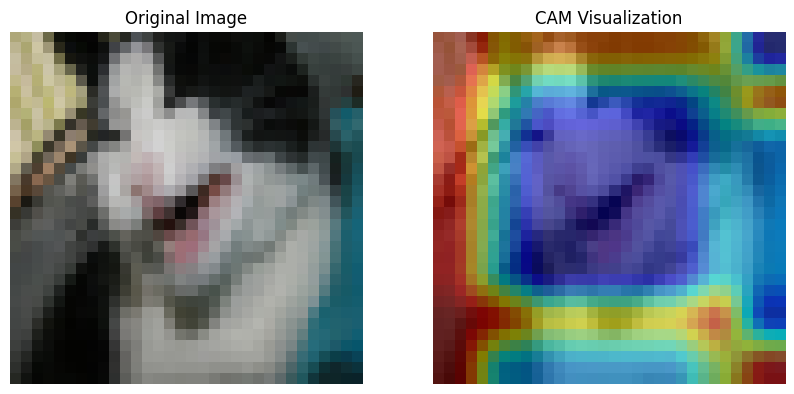

prediction:	cat
answer:		cat
1/1 [==============================] - 0s 93ms/step


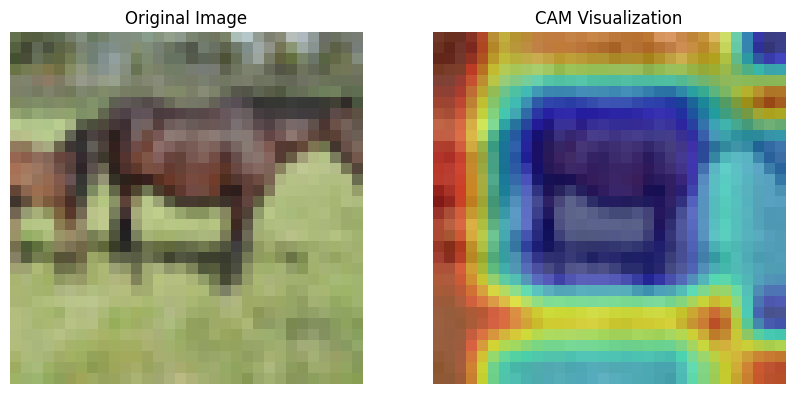

prediction:	horse
answer:		horse
1/1 [==============================] - 0s 119ms/step


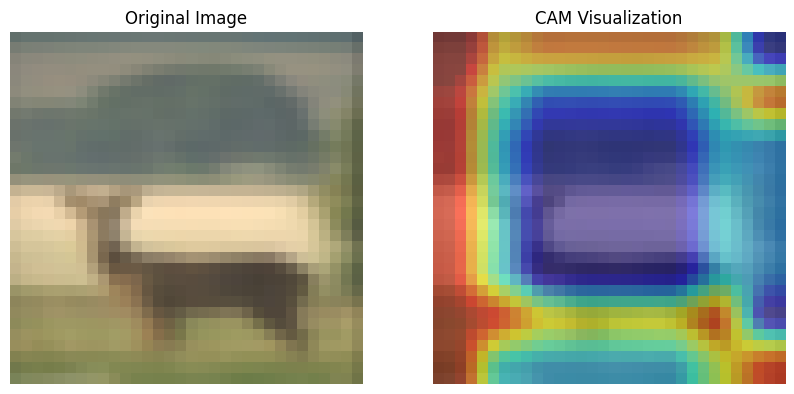

prediction:	deer
answer:		deer
1/1 [==============================] - 0s 138ms/step


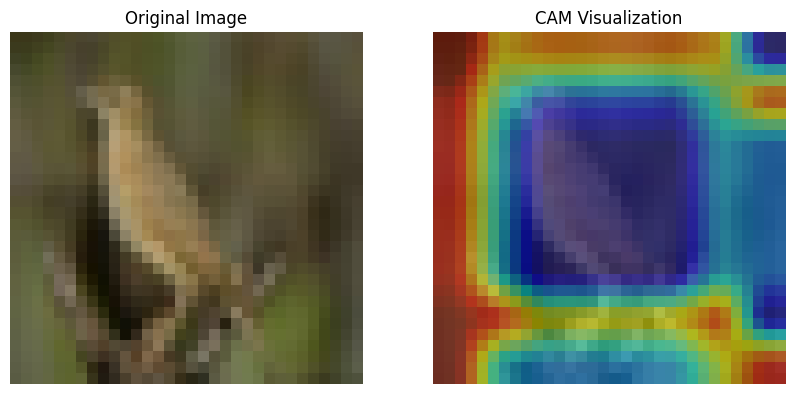

prediction:	bird
answer:		bird
1/1 [==============================] - 0s 125ms/step


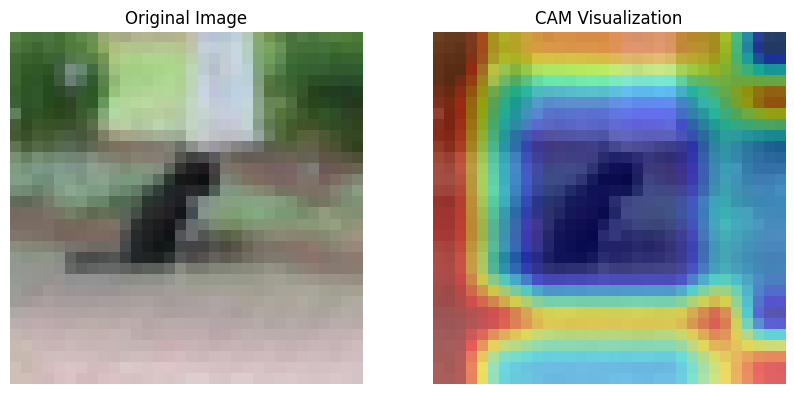

prediction:	bird
answer:		cat
1/1 [==============================] - 0s 156ms/step


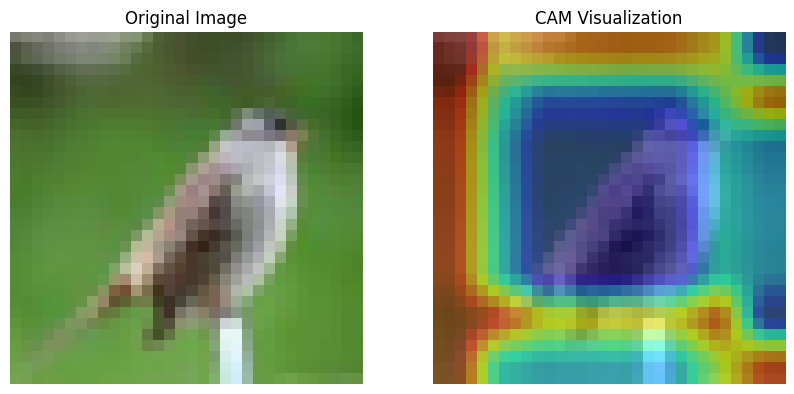

prediction:	bird
answer:		bird


In [12]:
category = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Select test image
for _ in range(15):
  index = np.random.randint(len(x_test))
  image = x_test[index]

  # Generate the CAM visualization
  cam_image = generate_cam(model, image)

  # Plot the original image and the CAM visualization
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
  ax1.imshow(image)
  ax1.axis('off')
  ax1.set_title('Original Image')
  ax2.imshow(cam_image)
  ax2.axis('off')
  ax2.set_title('CAM Visualization')
  plt.show()
  print(f"prediction:\t{category[np.argmax(features[index])]}")
  print(f"answer:\t\t{category[np.argmax(y_test[index])]}")

In [13]:
def get_kmeans_loss():
  features = model.predict(x_train)
  # Apply K-means clustering for manifold space learning and design loss function
  kmeans = KMeans(n_clusters=10, random_state=0, n_init=10)
  kmeans.fit(features)
  kmeans_labels = kmeans.labels_

  # Calculate centroids manually
  centroids = []
  for i in range(kmeans.n_clusters):
      cluster_points = features[kmeans_labels == i]
      centroid = np.mean(cluster_points, axis=0)
      centroids.append(centroid)
  kmeans_loss = [0 for _ in range(10)]
  for i in range(len(y_train)):
    min = float('INF')
    for j in range(10):
      tmp = np.linalg.norm(y_train[i] - centroids[j], 2)
      min = tmp if min > tmp else min
    kmeans_loss[np.argmax(y_train[i])] += min
  return kmeans_loss

In [14]:
tf.config.run_functions_eagerly(True)

#kmeans_loss = tf.constant(kmeans_loss)
#Vol.1 Euclidean distance 지금 1등
def my_loss1(label, predict):
  np_label = np.array(label)
  loss_table = [kmeans_loss[np.argmax(np_label[i])] for i in range(len(np_label))]
  loss = tf.norm(label-predict,2) * loss_table
  return loss


#Vol.2 Cosine similarity 나가리
def my_loss2(label, predict):
  cosine_similarity = tf.tensordot(label, tf.transpose(predict),axes=1)/(tf.norm(label,2)*tf.norm(predict,2))
  loss = 1 - cosine_similarity
  return loss * 100

#Vol.3 Manhattan distance
# Test Accuracy:  0.4722000062465668 그닥 좋지 않음 ㅠ_ㅠ
def my_loss3(label, predict):
  loss = tf.norm(label - predict,1)
  return loss

In [15]:
batch_size=64
model.compile(optimizer='adam',
              loss=my_loss1,
              metrics=['accuracy'])

In [ ]:
# Model Training
epochs = 10
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for _ in range(epochs):
  print(f"epochs {_}:")
  kmeans_loss = get_kmeans_loss()
  history = model.fit(x_train, y_train, batch_size=batch_size, epochs=1, callbacks=[tensorboard_cb], verbose=0)
  train_loss.append(history.history['loss'][0])
  train_acc.append(history.history['accuracy'][0])
  loss, acc = model.evaluate(x_test, y_test, verbose=0)
  test_loss.append(loss)
  test_acc.append(acc)

# Plot loss
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

epochs 0:


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



1563/1563 [==============================] - 16s 10ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



epochs 1:
1563/1563 [==============================] - 15s 10ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



epochs 2:
1563/1563 [==============================] - 15s 9ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



epochs 3:
1563/1563 [==============================] - 15s 9ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



In [ ]:
## Visualization of model evaluation

# Apply PCA for dimensionality reduction of test features
test_features = model.predict(x_test)
reduced_test_features = pca.fit_transform(test_features)

# Create a trace for the scatter plot
scatter_trace = go.Scatter3d(
    x=reduced_test_features[:, 0],
    y=reduced_test_features[:, 1],
    z=reduced_test_features[:, 2],
    mode='markers',
    marker=dict(
        color=y_test_origin.flatten(),
        colorscale='Viridis',
        size=3,
        opacity=0.8
    )
)

# Create the layout
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')
    ),
    title='Visualization of model evaluation-my loss'
)

# Create the figure
fig = go.Figure(data=[scatter_trace], layout=layout)

# Resize the figure
fig.update_layout(width=800, height=800)

# Show the figure
fig.show()
